# Gaussian distribution example

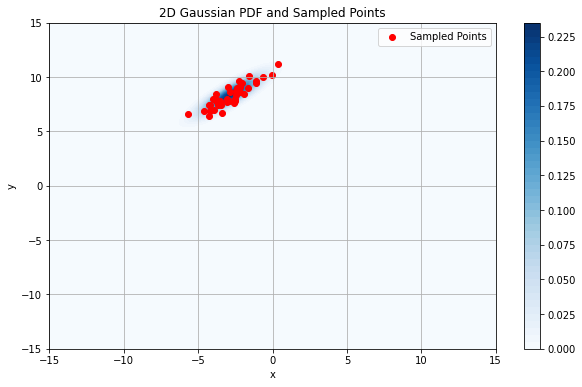

Actual covariance between the variables 1.1318602384170902


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Randomly choose mean for both dimensions
mu = np.array([np.random.uniform(-10, 10), np.random.uniform(-10, 10)])

# Randomly choose variances and a covariance for the covariance matrix
var_x = np.random.uniform(1, 5)
var_y = np.random.uniform(1, 5)
cov_xy = np.random.uniform(-2, 2)  # This value can be adjusted as needed

covariance = np.array([[var_x, cov_xy], [cov_xy, var_y]])

# Create a grid over which we'll evaluate the PDF
x, y = np.linspace(-15, 15, 100), np.linspace(-15, 15, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))
rv = multivariate_normal(mu, covariance)

# Sample 40 points from the distribution
samples = np.random.multivariate_normal(mu, covariance, 40)

# Plotting
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, rv.pdf(pos), levels=50, cmap="Blues")
plt.colorbar()
plt.scatter(samples[:, 0], samples[:, 1], color='red', marker='o', label='Sampled Points')
plt.title('2D Gaussian PDF and Sampled Points')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

print('Actual covariance between the variables', cov_xy)


Evaluate the sample means and correlation

In [15]:
# Calculate the sample means for each dimension
sample_means = np.mean(samples, axis=0)


print(f'Sample Mean for x: {sample_means[0]:.4f}')
print(f'Sample Mean for y: {sample_means[1]:.4f}')

# Calculate the sample correlation between x and y dimensions
sample_correlation = np.corrcoef(samples[:, 0], samples[:, 1])[0, 1]

print(f'Sample Correlation between x and y: {sample_correlation:.4f}')


Sample Mean for x: -2.8148
Sample Mean for y: 8.3036
Sample Correlation between x and y: 0.8924


Standard Deviation of Sample Covariance from 100 sets: 0.2721


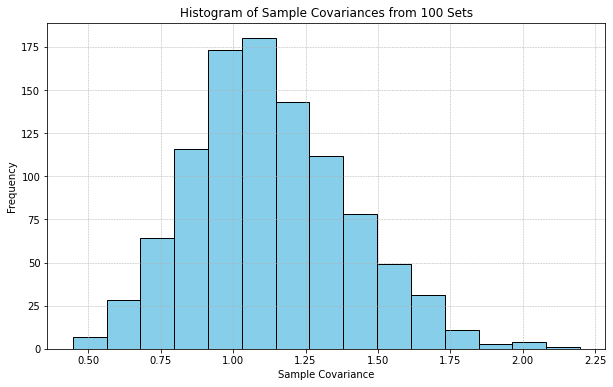

In [16]:
# Generate 100 sets of 40 samples each
num_sets = 1000
num_samples_per_set = 40
all_samples = [np.random.multivariate_normal(mu, covariance, num_samples_per_set) for _ in range(num_sets)]

# Compute the sample covariance for each set of samples
sample_covariances = [np.cov(sample_set, rowvar=False)[0, 1] for sample_set in all_samples]

# Calculate the standard deviation of the sample covariances
std_sample_covariance = np.std(sample_covariances, ddof=1)

print(f"Standard Deviation of Sample Covariance from 100 sets: {std_sample_covariance:.4f}")


# ... [previous code for generating samples and computing covariances]

# Plotting the histogram of the sample covariances
plt.figure(figsize=(10, 6))
plt.hist(sample_covariances, bins=15, color='skyblue', edgecolor='black')
plt.title('Histogram of Sample Covariances from 100 Sets')
plt.xlabel('Sample Covariance')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


Now lets perform a Jackknife estimate of the correlation error

In [9]:
def jackknife_corr(samples):
    """
    Compute the jackknife estimate for the correlation.
    
    Args:
    - samples (np.ndarray): The original 2D sample points.
    
    Returns:
    - float: The jackknife estimate of the standard error.
    """
    n = len(samples)
    jackknife_corrs = []

    for i in range(n):
        # Create a new sample by omitting the i-th observation
        jk_sample = np.delete(samples, i, axis=0)
        
        # Compute the correlation for the jackknife sample
        corr = np.corrcoef(jk_sample[:, 0], jk_sample[:, 1])[0, 1]
        jackknife_corrs.append(corr)

    # Calculate the jackknife estimate for standard error
    mean_corr = np.mean(jackknife_corrs)
    se = np.sqrt((n - 1) * np.sum((jackknife_corrs - mean_corr)**2))
    
    return se

# Calculate the jackknife estimate of standard error for the sample correlation
jk_se = jackknife_corr(samples)

print(f"Jackknife Estimate of Standard Error for Sample Correlation: {jk_se:.4f}")


Jackknife Estimate of Standard Error for Sample Correlation: 0.8613


Now lets perform a Bootstrap estimate of the correlation error

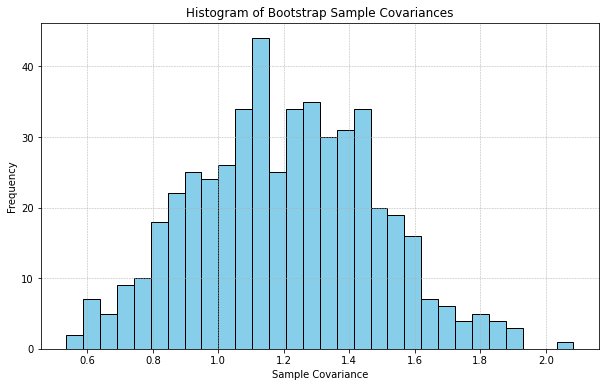

Standard Deviation of Bootstrap Sample Covariance: 0.2773


In [18]:
def bootstrap_covariance(samples, n_iterations=500):
    """
    Perform bootstrap resampling to estimate the distribution of the sample covariance.
    
    Args:
    - samples (np.ndarray): The original 2D sample points.
    - n_iterations (int): Number of bootstrap iterations.
    
    Returns:
    - list: List of covariances from the bootstrap samples.
    """
    n = len(samples)
    bootstrap_covariances = []

    for _ in range(n_iterations):
        # Randomly sample with replacement from the original samples
        bootstrap_sample = samples[np.random.choice(n, size=n, replace=True)]
        
        # Compute the covariance for the bootstrap sample
        cov = np.cov(bootstrap_sample, rowvar=False)[0, 1]
        bootstrap_covariances.append(cov)
    
    return bootstrap_covariances

# Use the previously generated 'single_sample_set'
bootstrap_results = bootstrap_covariance(samples)

# Calculate the standard deviation of the bootstrap covariances
std_bootstrap_covariance = np.std(bootstrap_results, ddof=1)

# Plotting the histogram of the bootstrap covariances
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_results, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Bootstrap Sample Covariances')
plt.xlabel('Sample Covariance')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

print(f"Standard Deviation of Bootstrap Sample Covariance: {std_bootstrap_covariance:.4f}")


## Comparing the parametric and non-parametric bootstrap

In [21]:
# Generate 50 samples from a 2D Gaussian
np.random.seed(42)  # for reproducibility

true_mean = [0, 0]  
true_cov = [[1, 0.5], [0.5, 1]]  # diagonal covariance, correlation = 0.5

x = np.random.multivariate_normal(true_mean, true_cov, 50)

# Estimate the mean and covariance from the generated samples
sample_mean = np.mean(x, axis=0)
sample_cov = np.cov(x, rowvar=False)

# Parametric bootstrap
B = 500  # Number of bootstrap samples
parametric_bootstrap_corrs = []

for _ in range(B):
    bootstrap_sample = np.random.multivariate_normal(sample_mean, sample_cov, 50)
    bootstrap_corr = np.corrcoef(bootstrap_sample, rowvar=False)[0, 1]
    parametric_bootstrap_corrs.append(bootstrap_corr)

parametric_bootstrap_variance = np.var(parametric_bootstrap_corrs, ddof=1)

# Non-parametric bootstrap
non_parametric_bootstrap_corrs = []

for _ in range(B):
    bootstrap_sample = x[np.random.choice(x.shape[0], size=50, replace=True)]
    bootstrap_corr = np.corrcoef(bootstrap_sample, rowvar=False)[0, 1]
    non_parametric_bootstrap_corrs.append(bootstrap_corr)

non_parametric_bootstrap_variance = np.var(non_parametric_bootstrap_corrs, ddof=1)

# Results
print('Sample mean: ', sample_mean)
print('Sample covariance: ', sample_cov)
print(f"Parametric Bootstrap Estimated Variance: {parametric_bootstrap_variance:.4f}")
print(f"Non-parametric Bootstrap Estimated Variance: {non_parametric_bootstrap_variance:.4f}")


Sample mean:  [0.15350725 0.08148984]
Sample covariance:  [[0.79350926 0.28023937]
 [0.28023937 0.73495833]]
Parametric Bootstrap Estimated Variance: 0.0164
Non-parametric Bootstrap Estimated Variance: 0.0202


## Example from lecture


   age   tot
0   18  2.44
1   19  3.86
2   19 -1.22
3   20  2.30
4   21  0.98
Sample correlation between age and tot: -0.5718387010425371


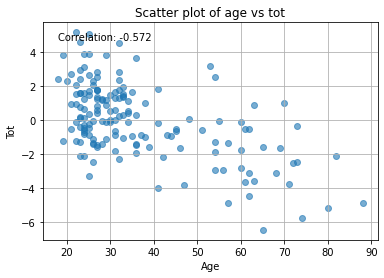

In [12]:
import pandas as pd

# URL of the dataset
url = "https://hastie.su.domains/CASI_files/DATA/kidney.txt"

# Load the dataset
data = pd.read_csv(url, delimiter=' ')  # Assuming the file is tab-separated; change delimiter as needed

# Display the first few rows
print(data.head())

correlation = data['age'].corr(data['tot'])
print("Sample correlation between age and tot:", correlation)

# Plot the data
plt.scatter(data['age'], data['tot'], alpha=0.6)
plt.title('Scatter plot of age vs tot')
plt.xlabel('Age')
plt.ylabel('Tot')
plt.grid(True)
plt.text(min(data['age']), max(data['tot']), f'Correlation: {correlation:.3f}', verticalalignment='top')
plt.show()


The Jackknife estimate of the standard error of the correlation

In [4]:
def jackknife_se(data, col1, col2):
    n = len(data)
    jackknife_corrs = []

    # Step 2: Compute correlations for n-1 samples
    for i in range(n):
        reduced_data = data.drop(i)  # Remove the i-th observation
        corr = reduced_data[col1].corr(reduced_data[col2])
        jackknife_corrs.append(corr)

    # Variance of jackknife correlations
    variance = sum([(jk - sum(jackknife_corrs)/n)**2 for jk in jackknife_corrs]) * (n-1)/n

    # Standard error
    se = variance**0.5

    return se

standard_error = jackknife_se(data, 'age', 'tot')

print(f"Jackknife estimated standard error for correlation: {standard_error}")


Jackknife estimated standard error for correlation: 0.05822858855212751


Now we perform the estimation with non-parametric bootstraping

In [8]:
def bootstrap_se(data, col1, col2, B=500):
    n = len(data)
    bootstrap_corrs = []

    # Step 2: Draw B bootstrap samples and compute correlations
    for _ in range(B):
        bootstrap_sample = data.sample(n, replace=True)  # Sampling with replacement
        corr = bootstrap_sample[col1].corr(bootstrap_sample[col2])
        bootstrap_corrs.append(corr)

    # Standard error is the standard deviation of bootstrap correlations
    se = np.std(bootstrap_corrs, ddof=1)

    return se

standard_error = bootstrap_se(data, 'age', 'tot')

print(f"Bootstrap estimated standard error for correlation: {standard_error}")


Bootstrap estimated standard error for correlation: 0.056186777423461017


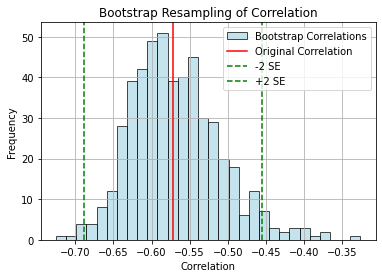

Original Correlation: -0.5718387010425371
Bootstrap SE: 0.05861253246077233
Original Correlation - 2*SE: -0.6890637659640817
Original Correlation + 2*SE: -0.4546136361209924


In [2]:
# Define function to compute correlation for bootstrap samples
def compute_bootstrap_corr(data, n_resamples=500):
    bootstrap_correlations = []
    for _ in range(n_resamples):
        bootstrap_sample = data.sample(len(data), replace=True)
        corr = bootstrap_sample['age'].corr(bootstrap_sample['tot'])
        bootstrap_correlations.append(corr)
    return np.array(bootstrap_correlations)

# Bootstrap resampling
bootstrap_correlations = compute_bootstrap_corr(data, 500)

# Compute original correlation and bootstrap standard error
original_corr = data['age'].corr(data['tot'])
bootstrap_se = np.std(bootstrap_correlations)

# Plot results
plt.hist(bootstrap_correlations, bins=30, color='lightblue', edgecolor='black', alpha=0.7, label='Bootstrap Correlations')
plt.axvline(original_corr, color='red', label='Original Correlation')
plt.axvline(original_corr - 2 * bootstrap_se, color='green', linestyle='--', label='-2 SE')
plt.axvline(original_corr + 2 * bootstrap_se, color='green', linestyle='--', label='+2 SE')
plt.title('Bootstrap Resampling of Correlation')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

print("Original Correlation:", original_corr)
print("Bootstrap SE:", bootstrap_se)
print("Original Correlation - 2*SE:", original_corr - 2*bootstrap_se)
print("Original Correlation + 2*SE:", original_corr + 2*bootstrap_se)
